# 040 Working with Pandas

> COM6018

*Copyright &copy; 2023 Jon Barker, University of Sheffield. All rights reserved*.

In this lab we are going to be working with Pandas. We will see how it can greatly simplify tasks that were quite challenging when using pure Python. To make this clear we will be starting by repeating the analysis we performed in Lab Class 020, ie. producing a plot of the combined Global Warming Potential of atmospheric methane and carbon dioxide over the last three decades. 

Start by briefly reviewing the solution notebook for Lab Class 020. Also make sure you have read through the Pandas tutorial notebook that will introduce a lot of the functionality that we will be using in this lab.


## Step 1 - Reading in the C02 data

Before we can use the Pandas package, we will need to import it. Pandas is conventionally imported with the name 'pd'. Run the cell below which will import both Pandas and NumPy.

In [1]:
import pandas as pd
import numpy as np

First, we will use the `pd.read_csv` method to load the carbon dioxide data from the CSV file, `data/co2.csv`. The loaded data will be stored in a Pandas dataframe which we will call `co2_df`. The CSV file has six fields which we will name as follows: 'Yr', 'Mn', 'Dy', 'CO2', 'NB', 'scale'. The `co2.csv` file has comment lines starting with a '%' symbol. These can be automatically skipped. If you are unsure how to do this then look again at the tutorial notebook, or check the documentation for `pd.read_csv`. 

Complete the cell below such that the TEST cell passes correctly.

In [2]:
# WRITE SOLUTION HERE

co2_df = pd.read_csv('data/co2.csv',header=None, names=['Yr','Mn','Dy','CO2','NB','scale'],skipinitialspace=True,comment='%')

In [3]:
# TEST
assert dict(co2_df.iloc[1000]) == {'Yr': 1960.0, 'Mn': 9.0, 'Dy': 27.0, 'CO2': 313.31, 'NB': 3.0, 'scale': 12.0}
print("All tests passed!")

All tests passed!


Note that all the fields have correctly been recognised as numeric types. The year, month and day fields would be more sensibly stored as integers but we are not going to worry about that for now. Note also that reading the data and converting to numeric types has taken one line of code. Compare this to the solution in Lab Class 020 which required quite a lot of code even when using the `csv` module.

## Step 2 - Reading in the CH<sub>4</sub> data

We will now read the methane data (i.e., CH<sub>4</sub>) from the file `data/ch4.csv` into a variable which we will call `ch4_df`. This can be done in a similar way but you will need to modify the `read_csv` parameters to match the CSV file contents. 

Note, the `data/ch4.csv` file has a row that stores the field names so you will not need to use the `names` parameter. Note also that the file uses the value '-999.99' to mean that there is a missing reading. You will need to set the 'na_values' parameter in order to handle this correctly. If in doubt, check the Pandas `read_csv` documentation.

Write the code below and then check it by running the test cell.


In [4]:
# WRITE SOLUTION HERE

ch4_df = pd.read_csv('data/ch4.csv',na_values='-999.99',skipinitialspace=True,comment='#',sep=' ')

In [5]:
# TEST
assert dict(ch4_df.iloc[1000]) == {'site_code': 'MLO', 'year': 1989, 'month': 9, 'day': 27, 'hour': 0, 'minute': 0, 'second': 0, 'time_decimal': 1989.7369863013696, 'value': 1696.03, 'value_std_dev': 7.04, 'nvalue': 7, 'latitude': 19.536, 'longitude': -155.576, 'altitude': 3437.0, 'elevation': 3397.0, 'intake_height': 40.0, 'qcflag': '...'}
print("All tests passed!")

All tests passed!


## Step 3 - Simplifying the data

We are now going to remove the fields that from each data frame that we are not interested in and rename the others. In our transformed dataframes we want just four columns: `year`, `month`, `day` and `co2_concentration` for the carbon dioxide data, and `year`, `month`, `day` and `ch4_concentration` for the methane data. 

Making a new dataframe from a subset of columns of an existing one is a very common operation. Check the tutorial notes if you cannot remember how to do this. To rename the fields we can use the DataFrame `rename` method. These two steps can be written in a single line of code. (Again, compare this with the equivalent step when we implemented this in Lab Class 020 without using Pandas.)

In [6]:
# WRITE SOLUTION HERE

#co2_df.head()
co2_df = co2_df[['Yr','Mn','Dy','CO2']].rename(columns={'Yr':'year','Mn':'month','Dy':'day','CO2':'co2_concentration'})
ch4_df = ch4_df[['year','month','day','value']].rename(columns={'value':'ch4_concentration'})

#co2_df.iloc[1000]

In [7]:
# TEST

assert dict(co2_df.iloc[1000]) == {'year': 1960.0, 'month': 9.0, 'day': 27.0, 'co2_concentration': 313.31}
assert dict(ch4_df.iloc[1000]) == {'year': 1989.0, 'month': 9.0, 'day': 27.0, 'ch4_concentration': 1696.03}
print('All tests passed!')



All tests passed!


## Step 4 - Dealing with missing values

In the next step we will remove any rows from the dataframes that contain missing concentration values. Check the notes on selecting rows. Hint: you can use the `isna()` method which returns True for data entries that have NaN values.

In [8]:
# WRITE SOLUTION HERE

idx1 = co2_df['co2_concentration'].isna()
idx2 = ch4_df['ch4_concentration'].isna()
co2_df = co2_df[~idx1]
ch4_df = ch4_df[~idx2]

In [9]:
# TEST
assert len(co2_df) == 17685
assert len(ch4_df) == 12111
print('All tests passed!')


All tests passed!


## Step 5 - Fixing the units

If you remember from Lab 2, the methane concentrations are stored as parts per billion, whereas the carbon dioxide is in parts per million. It will be more convenient to have them both in the same units (i.e., parts per million, *ppm*). This can be done simply by dividing the `ch4_concentration` values by 1000. 

Scaling a single column of a dataframe is very easy and can be done with a single line. Do this in the cell below.

In [10]:
# WRITE SOLUTION HERE

ch4_df['ch4_concentration'] = ch4_df['ch4_concentration']/1000

In [11]:
# TEST
print(ch4_df.ch4_concentration[92])
print('All tests passed!')

1.70002
All tests passed!


## Step 6 - Joining the data

We will now merge our dataframes into a single dataframe using the `merge` method.

We want to ignore any rows for which there is not both a CO<sub>2</sub> and a CH<sub>4</sub> measurement, i.e., if for a given day either the CO<sub>2</sub> *or* CH<sub>4</sub> measurement is missing then that day will not appear in the merged dataframe.  This is called an 'inner' join. We can specify that we want an 'inner' join by setting the `how` parameter to `inner` when we call the `merge` method.  

When performing a merge we need a unique identifier for each row. In our case we will use the combination of the 'year', 'month' and 'day' fields.  This is specified using the `on` parameter. 

The `merge` method returns a new dataframe which we will store in a variable called `df`.

This step can be completed with a single line. Check the notes if you are unsure.

In [12]:
# WRITE SOLUTION HERE

df = pd.merge(co2_df,ch4_df,how='inner',on=['year','month','day'])

In [13]:
# TEST
assert df['co2_concentration'][0] == 350.84
assert df['ch4_concentration'][0] == 1.70002
print('All tests passed')

All tests passed


Another advantage of using Pandas is that it is very fast. In the cell below, '%timeit' is used to time the `merge` command. On my machine is takes about 2 ms. This is faster than the function that we wrote in lab 2 when implementing the `merge` using Python.

In [14]:
%timeit co2_df.merge(ch4_df, how='inner', on=['day', 'month', 'year'])

2.62 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Step 7 - Processing the data

We will continue to follow the steps from Lab 020. We will now combine the CO<sub>2</sub> and CH<sub>4</sub> concentrations into a single value to represent the total 'Global Warming Potential' (GWP) of the gases. Remember, we can do this by converting all gas concentrations into 'CO<sub>2</sub> equivalent' (CO<sub>2</sub>e) and then summing them. For CH<sub>4</sub> we need to multiple by 28 to compute it's CO<sub>2</sub> equivalent.

So we will make a new column in the dataframe that we will call `co2e` and which will be equal to `co2_concentration + 28 * ch4_concentration`. This should be a single line of code. Refer to the notes if you are unsure how to do it. Write this in the cell below.


In [25]:
# WRITE SOLUTION HERE

df['co2e'] = df['co2_concentration']+(28*df['ch4_concentration'])

In [16]:
# TEST
assert df.co2e[0] == 398.44056
print('All tests passed!')

All tests passed!


## Step 8 -- Plotting the data

### Step 8.1 -- Plotting CO<sub>2</sub>e concentration over time

We are now ready to plot the data. We want to see a graph of the CO<sub>2</sub>e concentration over time.

Previously, in Lab 2, we used the matplotlib library to make the plot. Pandas makes things a bit easier as it has its own plotting tools builtin. The Data Series class has a plot method. e.g. to plot the `co2e` data we can use `df['co2e'].plot()` or, equivalently, `df.co2e.plot()`. The plot method has many parameters that can be used to control the appearance of the plot.

Make a plot with the title 'CO2e over time' and with the y-axis labeled as 'CO2e (ppm)' and the x-axis labeled as 'Year'

You will find that the x-axis will be the index of the row, ie from 0 to 9375. We would like it to be the year. Don't worry about this for now, we will fix it in the next step.



<AxesSubplot: title={'center': 'CO2e over time'}, xlabel='Year', ylabel='CO2e (ppm)'>

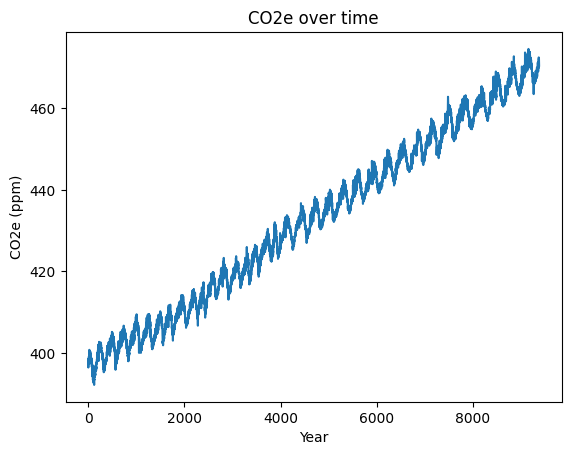

In [17]:
# WRITE SOLUTION HERE

df['co2e'].plot(title='CO2e over time',ylabel='CO2e (ppm)',xlabel='Year')

### Step 8.2 -- Plotting by decimal year

In order to get the x-axis right, we need to turn the date into a decimal number that we can plot against. 

Following what we did in Lab 2, we will use the following equation to convert the year, month and day into a single decimial year value,

`decimal_year = year + (month - 1) / 12 + (day - 1) / 365`

(Note, this equation is not quite correct as it assumes that each month is the same length, but it is good enough for our purposes.)

Add a new column to the DataFrame called `decimal_year` that is formed using the above equation.

In [18]:
# WRITE SOLUTION HERE

df['decimal_year'] = df['year'] + (df['month'] - 1) / 12 + (df['day'] - 1) / 365

In [19]:
# TEST
assert df.decimal_year[0] == 1987.2554794520547
print('All tests passed!')

All tests passed!


We can now plot the `co2_e` values against decimal year. To plot one column against another we can use the `plot` method of the dataframe itself and use the 'x' and 'y' parameters: this looks like `df.plot(x='decimial_year, y='co2e')`

Try this below, but remember to also give the plot a title and axes labels.

<AxesSubplot: title={'center': 'CO2e over time'}, xlabel='Year', ylabel='CO2e (ppm)'>

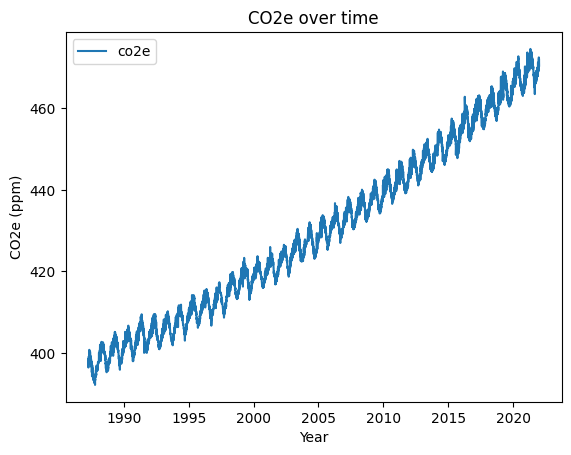

In [20]:
# WRITE SOLUTION HERE

df.plot(x='decimal_year',y='co2e',title='CO2e over time',ylabel='CO2e (ppm)',xlabel='Year')

We have now used Pandas to repeat everything we did in Lab class 020. Although it has taken a similar number of steps, each step could be completed with a single line of code using pre-existing Pandas functions. Each step will also have run faster.

## Step 9 - Extending the analysis

In this last step we are going to practice what we have just done by adding in data for two more global warming gases: nitrous oxide (N<sub>2</sub>O) and sulphur hexaflouride (SF<sub>6</sub>). The data for these gases is stored in the file `data/n2o.csv` and `data/sf6.csv`.

Using the techniques from above, read these files and add two new columns to the dataframe, i.e. `n2o_concentration` and `sf6_concentration` storing concentrations in parts per million (ppm).

Be careful to interpret the data correctly, i.e. the nitrous oxide data is recorded in parts per billion and the sulfur hexaflouride is measured as parts per trillion (i.e., 10^9). When computing the CO<sub>2</sub>e figure you can use the following multipliers: 265 for nitrous oxide and 23,500 for sulphur hexaflouride. (These values have been taken from the (IPCC fifth assessment report)[https://ghgprotocol.org/sites/default/files/ghgp/Global-Warming-Potential-Values%20%28Feb%2016%202016%29_1.pdf])


In [26]:
# WRITE SOLUTION HERE

n2o_df = pd.read_csv('data/n2o.csv',skipinitialspace=True,sep=' ',comment='#')
sf6_df = pd.read_csv('data/sf6.csv',skipinitialspace=True,sep=' ',comment='#')

n2o_df = n2o_df.rename(columns={'N2OcatsMLOyr':'year','N2OcatsMLOmon':'month','N2OcatsMLOday':'day','N2OcatsMLOm':'N2O'})
sf6_df = sf6_df.rename(columns={'SF6catsMLOyr':'year','SF6catsMLOmon':'month','SF6catsMLOday':'day','SF6catsMLOm':'SF6'})


n2o_df = n2o_df[['year','month','day','N2O']]
sf6_df = sf6_df[['year','month','day','SF6']]

idx3 = n2o_df['N2O'].isna()
idx4 = sf6_df['SF6'].isna()

n2o_df = n2o_df[~idx3]
sf6_df = sf6_df[~idx4]


#n2o_df.astype({'N2O':'float'})
#sf6_df.astype({'SF6':'float'})

n2o_df['N2O'] = n2o_df['N2O']/1000
sf6_df['SF6'] = sf6_df['SF6']/1000000

df = pd.merge(df,n2o_df,how='inner',on=['year','month','day'])
df = pd.merge(df,sf6_df,how='inner',on=['year','month','day'])

df['co2e'] += (265*df['N2O'])+(23500*df['SF6'])

#Now make a plot of the total CO2e.

<AxesSubplot: title={'center': 'CO2e over time'}, xlabel='Year', ylabel='CO2e (ppm)'>

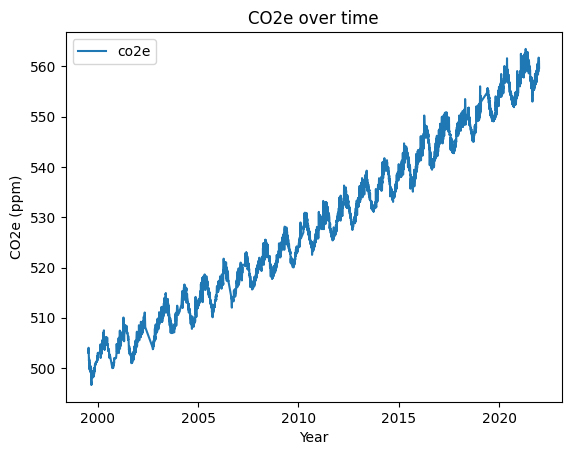

In [27]:
# WRITE SOLUTION HERE

df.plot(x='decimal_year',y='co2e',title='CO2e over time',ylabel='CO2e (ppm)',xlabel='Year')

You can plot multiple series on the same axes by setting the plot method's y parameter to be a list of the names of the series you want to plot, e.g., `y=['co2e', 'co2_concentration']`. Make a plot that shows the CO<sub>2</sub>e value for each of the four gases and the total CO<sub>2</sub>e, all plotted on the same axes. (Hint: in order to do this, you will first need to add new columns to the dataframe to store the CO<sub>2</sub>e of each of the separate gases.)

Write your code in the cell below.

<AxesSubplot: title={'center': 'CO2e over time'}, xlabel='Year', ylabel='CO2e (ppm)'>

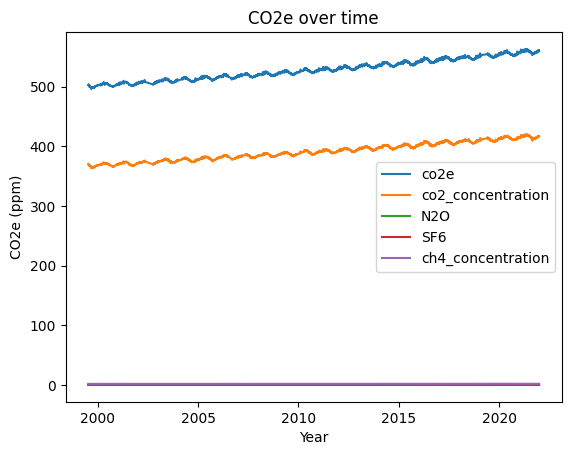

In [28]:
# WRITE SOLUTION HERE

df.plot(x='decimal_year',y=['co2e','co2_concentration','N2O','SF6','ch4_concentration'],title='CO2e over time',ylabel='CO2e (ppm)',xlabel='Year')

You should see from the plot that although the total CO<sub>2</sub>e has been steadily rising, nearly all of the increase is due to co2. i.e., the total CO<sub>2</sub>e line runs in parallel to the CO<sub>2</sub> line.

If all have gone well you should have produced a plot looking like the one below.

[final plot](figures/co2e_plot.png)

## Conclusion

In this lab, we learned how to use Pandas to load and process data from CSV files. We also learned how to merge data from multiple sources into a single dataframe, how to construct new DataSeries from existing ones, and how to plot the data using matplotlib.

All of these steps could have been done without Pandas, indeed, we did most of this in Lab 020 just using Python and standard library module. However, using Pandas has made the process considerably simpler to develop and faster to execute. Pandas also contains a lot of more sophisticated functionality that we have not covered here, but which is easy to learn (or look up!) once you have understood the basics. 

*Copyright &copy; 2023 Jon Barker, University of Sheffield. All rights reserved*.